Comencemos por importar las librerías necesarias

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Y por traer el código provisto para la generación de datos

In [4]:
def generar_datos_ruido(n, d, ruido=1e-1):
    """
    Genera una matriz A de tamaño (n, d+1) donde:
    - La primera columna contiene los valores b_i (términos independientes).
    - Las siguientes d columnas contienen los coeficientes a_ij.
    Samplea un vector x de tamaño d a partir de una distribución de Pareto.
    Samplea la matriz A de manera aleatoria normal.
    Samplea el vector b a partir de la matriz A y el vector x, agregando ruido gaussiano de magnitud ruido.
    """
    rng = np.random.default_rng(42)
    x = rng.pareto(a=3, size=d)
    A = np.random.randn(n, d)  # Matriz de coeficientes a_ij de tamaño (n, d)
    b = A @ x + ruido*np.random.randn(n)
    return np.hstack((b.reshape(n, 1), A))

def generar_outliers(m, d):
    """
    Genera una matriz A de tamaño (m, d+1) donde:
    - La primera columna contiene los valores b_i (términos independientes).
    - Las siguientes d columnas contienen los coeficientes a_ij.
    - m es la cantidad de outliers a agregar.
    """
    b = np.random.randn(m, 1)  # Vector b de tamaño (m, 1)
    A = np.random.randn(m, d)  # Matriz de coeficientes a_ij de tamaño (m, d)
    return np.hstack((b, A))

def generar_datos_outliers(n, d, outliers=5):
    """
    Genera una matriz A de tamaño (n, d+1) donde:
    - La primera columna contiene los valores b_i (términos independientes).
    - Las siguientes d columnas contienen los coeficientes a_ij.
    - n es la cantidad de muestras.
    - Se tienen (n-outliers) observaciones sin ruido
    - outliers es la cantidad de outliers a agregar.
    """
    rng = np.random.default_rng(42)
    x = rng.pareto(a=3, size=d)
    A1 = np.random.randn(n-outliers, d)  # Matriz de coeficientes a_ij de tamaño (m, d)
    b = A1 @ x
    A = np.hstack((b.reshape(n-outliers, 1), A1))
    A_outliers = generar_outliers(outliers, d)
    return np.vstack((A, A_outliers))

Ahora calculemos la derivada de $f$ para poder implementar el método del gradiente con backtracking.

Consideremos $r_i(x) = \langle a_i, x \rangle - b_i$, por lo que podemos escribir
$$f(x) = \sum_{i=1}^n |r_i(x)|$$
Usando la regla de la cadena tenemos que
$$\nabla_x |r_i(x)|^p = p |r_i(x)|^{p-1} \cdot sign(r_i(x)) \cdot \nabla_x r_i(x) = p |r_i(x)|^{p-1} \cdot sign(r_i(x)) \cdot a_i$$
Donde $sign(r_i(x))$ es la derivada del valor absoluto, es decir, corresponde a 1 o -1 dependiendo del signo de $r_i(x)$. Sumando sobre todos los $i$ resulta que
$$\nabla_x f(x) = \sum_{i=1}^n p |r_i(x)|^{p-1} \cdot sign(r_i(x)) \cdot a_i$$

In [5]:
def f(u, Ab, p):
    b = Ab[:, 0]
    A = Ab[:, 1:]
    r = np.dot(A, u) - b
    return np.sum(np.abs(r)**p)

def fgrad(u, Ab, p):
    b = Ab[:, 0]
    A = Ab[:, 1:]
    r = np.dot(A, u) - b
    grad = p*np.dot(A.T, (np.abs(r)**(p - 1))*np.sign(r))
    return grad

Ahora implementemos el método del gradiente con backtracking. Notemos que nos basta con acotar el gradiente puesto que por fuerte convexidad (parte (c) de la caracterización) se tiene que
$$[f(x_k) − v] \leq \frac{\lambda}{2}\|\nabla f(x_k)\|^2$$
Por lo que se puede comparar la garantía en norma de gradiente con la suboptimalidad en valor objetivo.

Además voy a agregar un número máximo de iteraciones al método del gradiente para aumentar la robustez del algoritmo

In [41]:
MAXITERS = 1000

def GradMethod(Ab, Lambda, x, delta, p):
    u = np.copy(x)
    eta = 1
    beta = 0.5
    iters = 0
    
    while True:
        grad = fgrad(u, Ab, p) + (1/Lambda)*(u - x)
        if np.linalg.norm(grad) < delta or iters == MAXITERS:
            break
        vu = f(u, Ab, p) + (1/(2*Lambda))*np.linalg.norm(x - u)**2
        while True:
            unew = u - eta*grad
            vunew = f(unew, Ab, p) + (1/(2*Lambda))*np.linalg.norm(x - unew)**2
            if vunew <= vu - eta/2*np.linalg.norm(grad)**2:
                u = unew
                break
            else:
                eta = beta*eta
        iters += 1
    return u

Y finalmente implementemos la función con la que obtendremos los oráculos inexactos

In [7]:
def OraculoInexacto(Ab, Lambda, x, delta, p):
    utilde = GradMethod(Ab, Lambda, x, delta, p)
    ftilde = f(utilde, Ab, p) + (1/(2*Lambda))*np.linalg.norm(x-utilde)**2 - delta
    gtilde = (1/Lambda)*(x-utilde)
    return ftilde, gtilde

Ahora implementemos el método de la pregunta 3

In [44]:
def InexactGradMethod(Ab, Lambda, x0, delta, p):
    K = Lambda.shape[0]
    x = x0.copy()
    xsum = np.zeros(Ab.shape[1] - 1)
    etasum = 0.0
    
    for k in range(K):
        Lambdak = Lambda[k]
        deltak = delta[k]
        Lk = 1/Lambdak
        etak = 1/Lk
        
        ftilde, gtilde = OraculoInexacto(Ab, Lambdak, x, deltak, p)
        x = x - etak*gtilde
        
        xsum += etak*x
        etasum += etak
    
    xres = xsum/etasum
    
    return xres

Generemos los datos

In [9]:
n = 1000
ds = [1, 10, 100]
As_ruido = [generar_datos_ruido(n, d) for d in ds]
As_outliers = [generar_datos_outliers(n, d,np.floor(0.01*n).astype(int)) for d in ds]

Hagamos una función que calcule el error cuadrático medio y que grafique. Además voy a asignar hacer 100 iteraciones del método y voy a crear una función para hacer los experimentos más fácilmente.

In [68]:
def ECM(Ab, x):
    return f(x, Ab, 2)/Ab.shape[0]

def plot(Ab, x, text):
    y = Ab[:, 0]
    X = Ab[:, 1:]

    x_line = np.linspace(min(X), max(X), 100)
    y_line = x*x_line

    plt.figure(figsize=(5, 3))
    plt.scatter(X, y, alpha=0.5)
    plt.plot(x_line, y_line, color='red')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(text)
    plt.grid(True)
    plt.show()

def experimentar(p, d, K = 100, graficar = False):
    
    Lambda = np.array([1e-3 for _ in range(K)])
    delta = np.array([1e-4 for _ in range(K)])
    x0 = np.array([0 for _ in range(As_ruido[d].shape[1] - 1)])

    xf = InexactGradMethod(As_ruido[d], Lambda, x0, delta, p)
    xfo = InexactGradMethod(As_outliers[d], Lambda, x0, delta, p)

    delta = np.array([1/np.sqrt(k+1) for k in range(K)])

    xv = InexactGradMethod(As_ruido[d], Lambda, x0, delta, p)
    xvo = InexactGradMethod(As_outliers[d], Lambda, x0, delta, p)

    print(f"ECM para p = {p} y d = {x0.shape[0]}")
    print(f"ECM con delta fijo sin outliers: {ECM(As_ruido[d], xf):.6f}")
    print(f"ECM con delta variable sin outliers: {ECM(As_ruido[d], xv):.6f}")
    print(f"ECM con delta fijo con outliers: {ECM(As_outliers[d], xfo):.6f}, y exluyendo a los outliers del ECM: {ECM(As_outliers[d][:int(As_outliers[d].shape[0]/1.01)], xfo):.6f}")
    print(f"ECM con delta variable con outliers: {ECM(As_outliers[d], xvo):.6f}, y exluyendo a los outliers del ECM: {ECM(As_outliers[d][:int(As_outliers[d].shape[0]/1.01)], xvo):.6f}")
    print()

    if graficar == True:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        
        def plot_subplot(ax, Ab, x, text):
            y = Ab[:, 0]
            X = Ab[:, 1:]

            x_line = np.linspace(min(X), max(X), 100)
            y_line = x * x_line

            ax.scatter(X, y, alpha=0.5)
            ax.plot(x_line, y_line, color='red')
            ax.set_xlabel('X')
            ax.set_ylabel('y')
            ax.set_title(text)
            ax.grid(True)

        plot_subplot(axs[0, 0], As_ruido[d], xf, 'Delta fijo sin outliers')
        plot_subplot(axs[0, 1], As_ruido[d], xv, 'Delta 1/sqrt(k) sin outliers')
        plot_subplot(axs[1, 0], As_outliers[d], xfo, 'Delta fijo con outliers')
        plot_subplot(axs[1, 1], As_outliers[d], xvo, 'Delta 1/sqrt(k) con outliers')

        plt.tight_layout()
        plt.show()

Comencemos con los experimentos. Primero veamos para $p = 1.2$ y una dimensión

ECM para p = 1.2 y d = 1
ECM con delta fijo sin outliers: 0.009884
ECM con delta variable sin outliers: 0.009884
ECM con delta fijo con outliers: 0.016182, y exluyendo a los outliers del ECM: 0.000018
ECM con delta variable con outliers: 0.016182, y exluyendo a los outliers del ECM: 0.000018



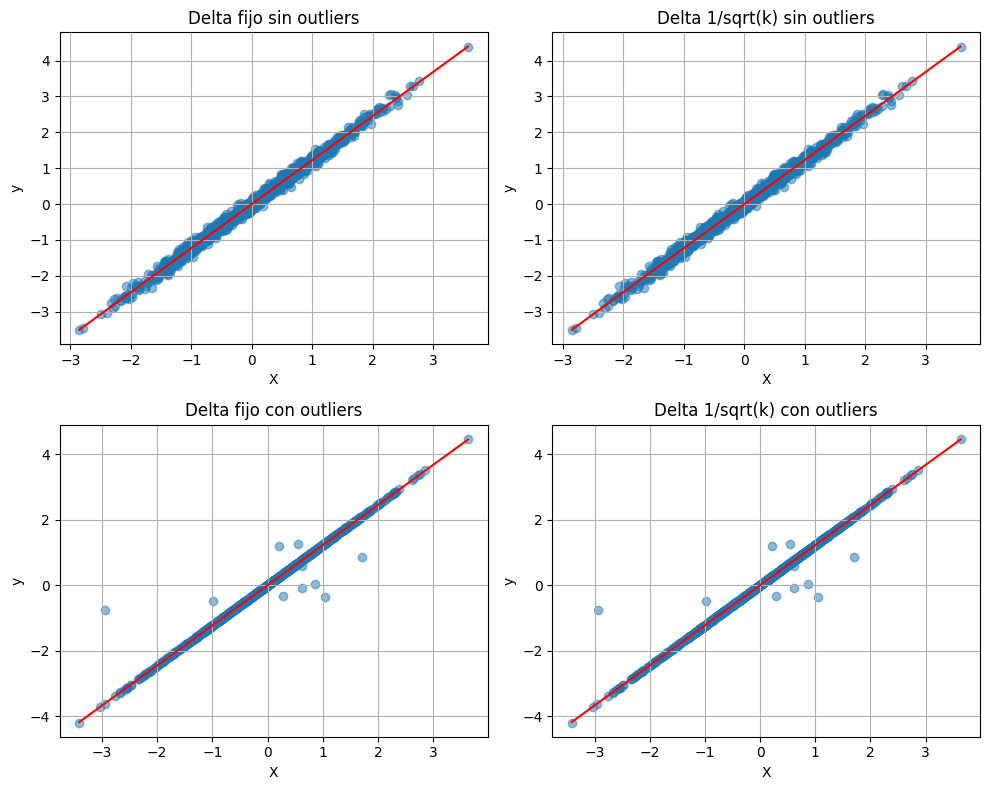

In [69]:
experimentar(1.2, 0, graficar = True)

Se ve que la recta se ajustó correctamente. Notemos que el ECM sin considerar outliers es mucho menor ya que esos datos no tenían ruido extra, entonces al sacar los outliers es mucho mejor para una regresión lineal

Ahora veamos para $p = 2$ y una dimensión

ECM para p = 2 y d = 1
ECM con delta fijo sin outliers: 0.009908
ECM con delta variable sin outliers: 0.009909
ECM con delta fijo con outliers: 0.016128, y exluyendo a los outliers del ECM: 0.000384
ECM con delta variable con outliers: 0.016128, y exluyendo a los outliers del ECM: 0.000386



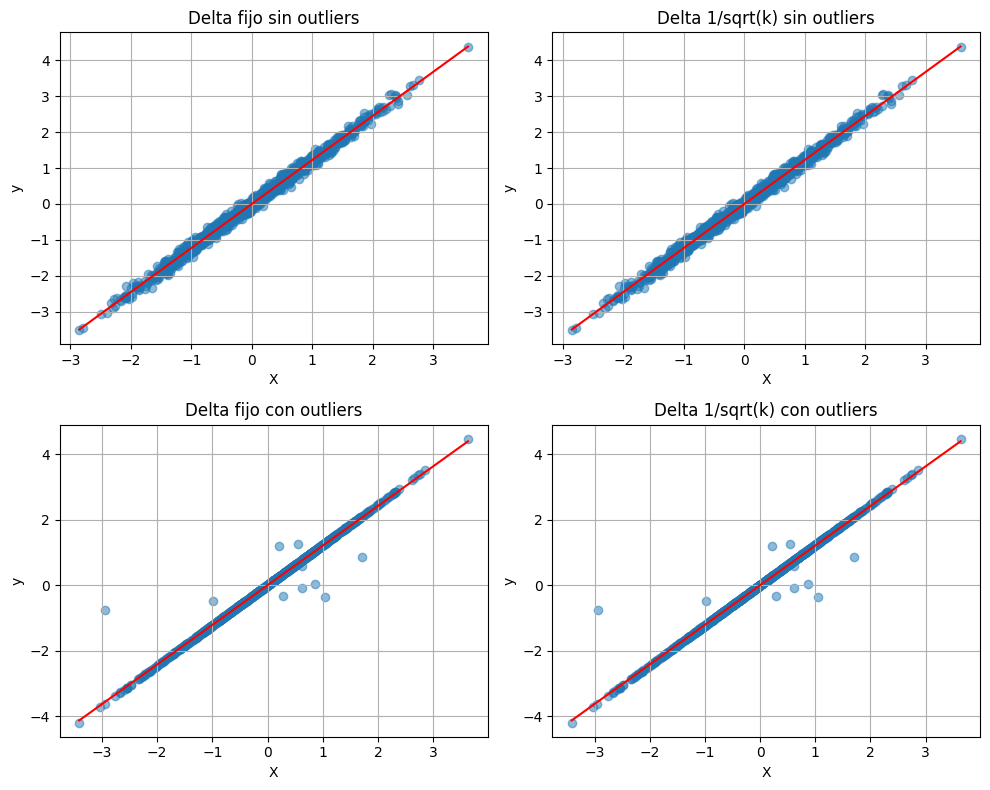

In [70]:
experimentar(2, 0, graficar = True)

Nuevamente el ajuste fue muy bueno

Y ahora veamos para $p = 10$ y una dimensión

ECM para p = 10 y d = 1
ECM con delta fijo sin outliers: 0.032952
ECM con delta variable sin outliers: 0.033489
ECM con delta fijo con outliers: 0.175681, y exluyendo a los outliers del ECM: 0.169922
ECM con delta variable con outliers: 0.175682, y exluyendo a los outliers del ECM: 0.169923



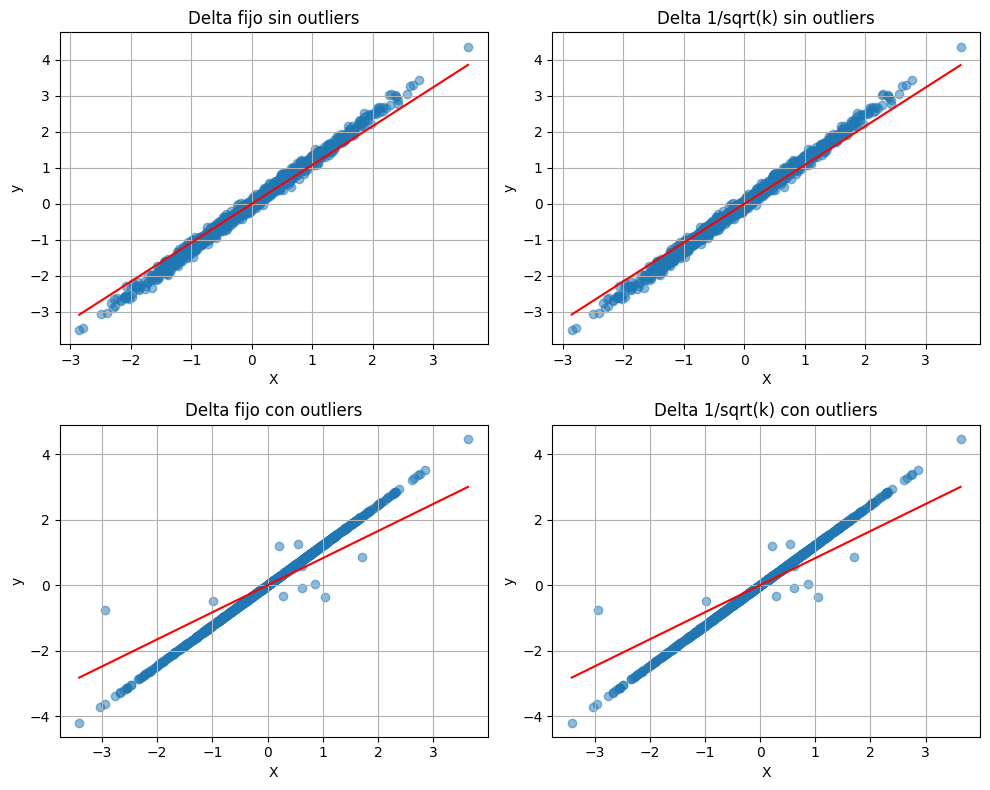

In [71]:
experimentar(10, 0, graficar = True)

En este caso el ajuste empeoró, y se nota mucho más para los casos con outliers. Esto se debe a que a mayor p pesan mucho más los puntos extremos, de hecho cuando p tiende a infinito el problema sería minimizar el máximo, lo cual es basicamente ajustar los outliers.

Ahora veamos experimentos para una dimensión mayor

In [72]:
experimentar(1.2, 1)
experimentar(2, 1)
experimentar(10, 1)

ECM para p = 1.2 y d = 10
ECM con delta fijo sin outliers: 0.011105
ECM con delta variable sin outliers: 0.011106
ECM con delta fijo con outliers: 0.128076, y exluyendo a los outliers del ECM: 0.000931
ECM con delta variable con outliers: 0.128076, y exluyendo a los outliers del ECM: 0.000932

ECM para p = 2 y d = 10
ECM con delta fijo sin outliers: 0.010550
ECM con delta variable sin outliers: 0.010551
ECM con delta fijo con outliers: 0.124567, y exluyendo a los outliers del ECM: 0.006327
ECM con delta variable con outliers: 0.124569, y exluyendo a los outliers del ECM: 0.006331

ECM para p = 10 y d = 10
ECM con delta fijo sin outliers: 0.041920
ECM con delta variable sin outliers: 0.042557
ECM con delta fijo con outliers: 0.971404, y exluyendo a los outliers del ECM: 0.940464
ECM con delta variable con outliers: 0.971404, y exluyendo a los outliers del ECM: 0.940464



Se ve que los resultados son bastantes razonables, y que el tiempo de ejecución también es razonable, por lo cual el método está funcionando muy bien

In [73]:
experimentar(1.2, 2)
experimentar(2, 2)
experimentar(10, 2)

ECM para p = 1.2 y d = 100
ECM con delta fijo sin outliers: 0.045685
ECM con delta variable sin outliers: 0.045710
ECM con delta fijo con outliers: 0.528376, y exluyendo a los outliers del ECM: 0.037422
ECM con delta variable con outliers: 0.528394, y exluyendo a los outliers del ECM: 0.037452

ECM para p = 2 y d = 100
ECM con delta fijo sin outliers: 0.010645
ECM con delta variable sin outliers: 0.010648
ECM con delta fijo con outliers: 0.468247, y exluyendo a los outliers del ECM: 0.056045
ECM con delta variable con outliers: 0.468251, y exluyendo a los outliers del ECM: 0.056050

ECM para p = 10 y d = 100
ECM con delta fijo sin outliers: 0.095313
ECM con delta variable sin outliers: 0.096238
ECM con delta fijo con outliers: 2.660877, y exluyendo a los outliers del ECM: 2.601206
ECM con delta variable con outliers: 2.660877, y exluyendo a los outliers del ECM: 2.601206



Nuevamente los resultados tanto en precisión y en tiempo de ejecución parecieran ser bastante razonables.